In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import torchvision
from torchvision import transforms
from torchvision.utils import save_image

from PIL import Image
from collections import OrderedDict
import matplotlib.pyplot as plt
import torch

import time
import os 
image_dir = os.getcwd() + '/Images/'
model_dir = os.getcwd() + '/Models/'

In [2]:
#vgg that grab the outputs from any layer
class VGG(nn.Module):
    def __init__(self, pool='max'):
        super(VGG, self).__init__()
#         torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros'
     
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)#vgg modules
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        
        if pool == 'max':
            self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
            
        elif pool == 'avg':
            self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.AvgPool2d(kernel_size=2, stride=2)
            
    def forward(self, x, out_keys):
        out = {}
        
        out['r11'] = F.relu(self.conv1_1(x))
        out['r12'] = F.relu(self.conv1_2(out['r11']))
        out['p1'] = self.pool1(out['r12'])
        
        out['r21'] = F.relu(self.conv2_1(out['p1']))
        out['r22'] = F.relu(self.conv2_2(out['r21']))
        out['p2'] = self.pool2(out['r22'])
        
        out['r31'] = F.relu(self.conv3_1(out['p2']))
        out['r32'] = F.relu(self.conv3_2(out['r31']))
        out['r33'] = F.relu(self.conv3_3(out['r32']))
        out['r34'] = F.relu(self.conv3_4(out['r33']))
        out['p3'] = self.pool3(out['r34'])
        
        out['r41'] = F.relu(self.conv4_1(out['p3']))
        out['r42'] = F.relu(self.conv4_2(out['r41']))
        out['r43'] = F.relu(self.conv4_3(out['r42']))
        out['r44'] = F.relu(self.conv4_4(out['r43']))
        out['p4'] = self.pool4(out['r44'])
        
        out['r51'] = F.relu(self.conv5_1(out['p4']))
        out['r52'] = F.relu(self.conv5_2(out['r51']))
        out['r53'] = F.relu(self.conv5_3(out['r52']))
        out['r54'] = F.relu(self.conv5_4(out['r53']))
        out['p5'] = self.pool5(out['r54'])
        
        return [out[key] for key in out_keys]

In [3]:
# gram matrix 
class GramMatrix(nn.Module):
    def forward(self, input):
        #batch size, depth, height, weight of the input
        b,d,h,w = input.size()
        F = input.view(b, d, h*w) #reshape so we multiply the features for eache chanel
        #calculate gram matrix
        G = torch.bmm(F, F.transpose(1,2)) 
        G.div_(h*w)
        return G
#loss
class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = nn.MSELoss()(GramMatrix()(input), target)
        return(out)

In [4]:
# pre and post processing for images
image_size = 512 
prep_prossesing = transforms.Compose([transforms.Scale(image_size),
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #it makes it to BGR
                           transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], #imagenet mean is subtracted
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x.mul_(255)),
                          ])
post_prossesing1 = transforms.Compose([transforms.Lambda(lambda x: x.mul_(1./255)),
                           transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], #add imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turns it to RGB
                           ])
post_prossesing2 = transforms.Compose([transforms.ToPILImage()])

def postProssesing(tensor): # clip results in the range [0,1]
    t = post_prossesing1(tensor)
    t[t>1] = 1    
    t[t<0] = 0
    image = post_prossesing2(t)
    return image

C:\Users\bacso\anaconda3\lib\site-packages\torchvision\transforms\transforms.py:285: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [5]:
#get network
vgg = VGG()
vgg.load_state_dict(torch.load(model_dir + 'vgg_conv.pth'))
for param in vgg.parameters():
    param.requires_grad = False
if torch.cuda.is_available():
    vgg.cuda()

In [6]:
#loading images,the first is style image second content image(is a picture from my galery)
image_dirs = [image_dir, image_dir]
# image_names = ['vangogh_starry_night.jpg', 'IMG077.jpg']
image_names = ['autumn.jpg', 'IMG557.jpg']
images = [Image.open(image_dirs[i] + name) for i,name in enumerate(image_names)]
images_torch = [prep_prossesing(image) for image in images]
if torch.cuda.is_available():
    images_torch = [Variable(image.unsqueeze(0).cuda()) for image in images_torch]
else:
    images_torch = [Variable(image.unsqueeze(0)) for image in images_torch]

style_image, content_image = images_torch

opt_image = Variable(content_image.data.clone(), requires_grad=True)

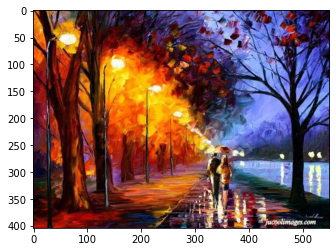

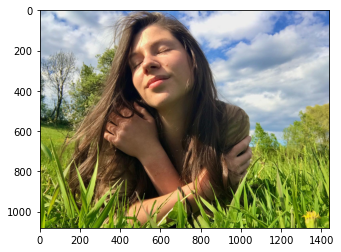

In [7]:
#afisarea pozelor
for image in images:
    plt.imshow(image); 
    plt.show()

In [8]:
#definim layeri si functiile de loss
style_layers = ['r11','r21','r31','r41', 'r51'] 
content_layers = ['r42']

loss_layers = style_layers + content_layers
loss_fns = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)

if torch.cuda.is_available():
    loss_fns = [loss_fn.cuda() for loss_fn in loss_fns]
    
#setarea weightsurilor
style_weights = [1e3/n**2 for n in [64,128,256,512,512]]
content_weights = [1e0]
weights = style_weights + content_weights

#calculam opt. targets
style_targets = [GramMatrix()(A).detach() for A in vgg(style_image, style_layers)]
content_targets = [A.detach() for A in vgg(content_image, content_layers)]
targets = style_targets + content_targets

Iteratia: 50, si loss-ul: 5933171.000000
Iteratia: 100, si loss-ul: 2145291.500000
Iteratia: 150, si loss-ul: 1429099.250000
Iteratia: 200, si loss-ul: 1081419.000000
Iteratia: 250, si loss-ul: 891497.375000
Iteratia: 300, si loss-ul: 772873.812500
Iteratia: 350, si loss-ul: 694990.000000
Iteratia: 400, si loss-ul: 637465.000000
Iteratia: 450, si loss-ul: 599013.937500
Iteratia: 500, si loss-ul: 569767.125000


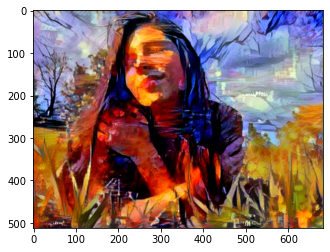

In [9]:
#aici facem style transfer
max_iteration = 500
show_itertion = 50
#LBFGS=Limited-memory Broyden-Fletcher-Goldfarb-Shanno Algorithm
optimizer = optim.LBFGS([opt_image]); 
n_iteration=[0]

while n_iteration[0] <= max_iteration:

    def closure():
        optimizer.zero_grad()
        out = vgg(opt_image, loss_layers)
        layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a,A in enumerate(out)]
        loss = sum(layer_losses)
        loss.backward()
        n_iteration[0]+=1
        
        if n_iteration[0]%show_itertion == (show_itertion-1):
            
#             print([loss_layers[li] + ': ' +  str(l.data[0]) for li,l in enumerate(layer_losses)]) #afiseaza lossul pe fiecare layer
            print('Iteratia: %d, si loss-ul: %f'%(n_iteration[0]+1, loss.item()))    
        return loss
    
    optimizer.step(closure)
    
#afisam rezulatul
out_image = postProssesing(opt_image.data[0].cpu().squeeze())
plt.imshow(out_image)

In [1]:
#salvam poza generata 

In [ ]:
#am ramas la impelemtarea high resolution style transfer............
#si sa testez si pe alte poze(content) si style images cum merge